# Signall Processing工具使用

在理論課程中已有補充數位信號處裡的基礎與常見分析方式。

這邊我們介紹用python完成這些訊號處裡的一些工具，方便後面AI modeling時使用。

我們主要會聚焦在聲音處裡上，不過其中很多概念與工具都可以用在其他訊號的處理。

課程包含以下內容:
* Audio data
* Up/Down Sampling
* Fast Fourier Transform
* Short-Time Fourier Transform

In [ ]:
# 處理音訊最常用librosa
!pip install librosa

In [1]:
import librosa
import IPython.display as idp # 播音工具
import numpy as np # 輔助運算
import matplotlib.pyplot as plt # 輔助畫圖
from plotly import express as px


In [2]:
def plot_signal(signal,sr, start=0, end=None, labels=None,title=None):
    
    ## Visualizes signal data
    ## Args:
    #  signal (list of array of int) - 時間點對應的訊號，列表內時間序列數量為D，每筆資料長度為T，若非為列表則轉為列表
    #  start (int) - 開始的資料序(第幾筆)
    #  end (int) -   結束繪製的資料序(第幾筆)
    #  labels (list of strings)- 對於多時間序列或多維度的標註
    #  title (string)- 圖片標題
    
    # 若資料只有一筆，則轉為list
    if type(signal)!=list:
        signal=[signal]
        
    if not end:
        end=len(signal[0])
    time=(np.arange(len(signal[0]))/sr)[start:end]
    if labels:
    # 設立dictionary, 讓plotly畫訊號線時可以標註label    
        dictionary={"time":time}
        for idx,l in enumerate(labels):
            # 截斷資料，保留想看的部分，並分段紀錄於dictionary中
            dictionary.update({l:signal[idx][start:end]})
        # 畫訊號線
        fig = px.line(dictionary,x="time",y=list(dictionary.keys())[1:],width=1000, height=400,title=title)
    else:
        # 畫訊號線
        fig = px.line(x=time,y=signal,width=1000, height=400,title=title)
    fig.show()

## Audio Data

我們可以使用Librosa讀取資料，這邊使用鋼琴聲
(Mozart, Sonata K.331 - I. Andante grazioso)

In [3]:
!gdown https://drive.google.com/u/0/uc?id=1xOfGFiCQXNOkolPOdm2mC9Wh5Yx05cVJ&export=download

Downloading...
From: https://drive.google.com/u/0/uc?id=1xOfGFiCQXNOkolPOdm2mC9Wh5Yx05cVJ
To: /content/signal_piano.wav
100% 441k/441k [00:00<00:00, 90.0MB/s]


In [4]:
## 使用librosa.load可以讀取檔案，讀出來預設是float32格式
# 'path' - 檔名
# 'sr' - 可以指定聲音檔讀出來後的sampling rate

piano_,sr=librosa.load("signal_piano.wav") # 讀出訊號檔以及sampling rate
# 使用IPython的display.Audio可以放出來試聽
idp.Audio("signal_piano.wav")

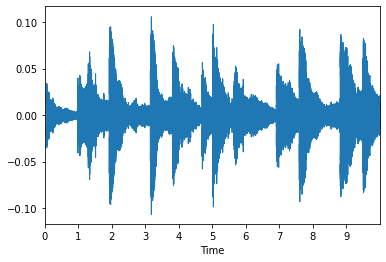

In [5]:
%matplotlib inline
# 使用librosa的display.waveplot可以將圖畫出來，並且對上實際時間做為參考
ldp.waveplot(piano_,sr=sr)

In [6]:
# librosa那邊的圖不太能操控或縮放，所以也可以自己用plotly寫的比較好操控，可以Zoom-in
plot_signal(piano_,sr,labels=['piano'])

把訊號畫出來對解析很重要，但每種情況可能需求都不太一樣

例如音訊可能十分密集，所以可能可以不需要看得太細，可以稍微re-sample一下

## Re-Sampling

Sampling rate的調整是處理訊號重要的一環，要是要將兩個訊號疊加，但發現兩者雖然sample數相同sampling rage卻不相符則會有錯誤的疊加效果。

Re- sampling有各種方法，對訊號皆有擾動，詳細可參考librosa官網參數```res_type```:
https://librosa.org/doc/main/generated/librosa.resample.html

預設的就一般訊號分析來講很夠用了。

### Downsample

In [7]:
# Downsample 減少sampling rate,也減少資料點數
piano_3000=librosa.resample(piano_,orig_sr=sr,target_sr=3000)

In [8]:
# 同樣是10秒錄音，在resample後點數會變少
print(len(piano_),len(piano_3000))
# 若是需求的sampling rate剛好是原本的因數，那也可以直接依downsample的倍率做sample
piano_11025=piano_[::2]
print(len(piano_),len(piano_11025))

220500 30001
220500 110250


In [9]:
# 可聽出聲音變得比較朦朧，第一是downsample後失真，第二也是人類對特定頻段較有知覺，剛好有些頻段被截掉了
# 參考 https://en.wikipedia.org/wiki/Equal-loudness_contour
idp.Audio(piano_3000,rate=3000)

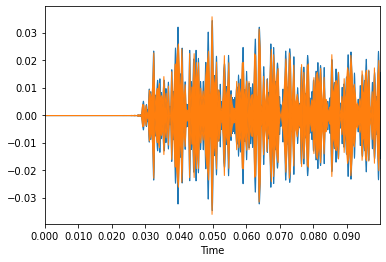

In [10]:
# 從waveplot上可以看到在經過downsample後 有點失真了
ldp.waveplot(piano_[:int(0.1*sr)],sr=sr)
ldp.waveplot(piano_3000[:int(0.1*3000)],sr=3000)

### Upsample

In [11]:
# Upsample 增加sampling rate,也增加資料點數
piano_44100=librosa.resample(piano_,orig_sr=sr,target_sr=44100)

In [12]:
# 可看一下資料數
print(len(piano_),len(piano_44100))

220500 441000


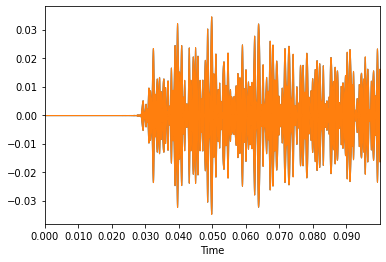

In [13]:
# 在upsample時不會有失真的情況，因為是類似在資料間插值補值
ldp.waveplot(piano_[:int(0.1*sr)],sr=sr)
ldp.waveplot(piano_44100[:int(0.1*44100)],sr=44100)

一般來講upsampling都不存在標準答案，因為就是sampling rate不夠才要補。

Upsampling本身後來在AI圈也變成一個議題，叫Super Resolution，使用訓練好的神經網路模型來做upsampling增加解析度。

## Fast Fourier Transform

分析訊號的成分最常見的方式是頻譜分析，連續訊號可以藉由Fourier Transform得到頻譜，也就是訊號在頻率上的分布。

而對於數位訊號，我們可以藉由Discrete Fourier Transform得到頻譜
$$𝐗_k≔\sum\limits_{𝑛=0}^{𝑁−1}𝑥_𝑛 𝑒^{(−𝑗2𝜋𝑘𝑛/𝑁)}$$

<img src=https://i.imgur.com/CZh8cYU.png width=800>


Scipy或者其他套件包有提供一些方式做快速的Discrete Fourier Transform，稱為Fast Fourier Transform(FFT)。

若是訊號分析則用Scipy就好，若是要整合到神經網路上可能就得使用Tensorflow或Pytorch內建的fft。

In [14]:
from scipy import fft 

$$$$這邊因為我們做的是離散的Fourier轉換，若要看到原本單位(seconds, Hz)則需進行轉換。
* 時間: $n=f_s t$
* 頻率: $k=f N /f_s$

N為參與FFT的點數，$f_s$則是sampling rate。

Text(0.5, 0, 'frequency(Hz)')

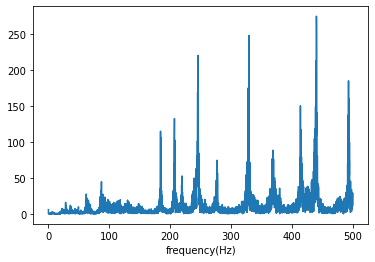

In [37]:
## 使用scipy.fft.fft可以對訊號做fft
# 'x' - 資料
# 'n' - FFT點數，通常不指定，預設為資料總點數
# 記得做完Fourier Transform後不管是continuous/discrete/fast Fourier Transform, 出來都是複數 (預設為complex64格式)
N=len(piano_)
piano_f = fft.fft(piano_[:N])
frequency=np.linspace(0,sr,N)
max_f=500 # 設定想看到的最大頻率 (Hz)
max_k=int(max_freq*N/sr) # 轉成k
plt.plot(frequency[:max_k], abs(piano_f[:max_k])) # 通常我們是看這個複數的magnitude, 取absolute就可以做到
plt.xlabel("frequency(Hz)")

在頻譜圖中我們可以看到較為高峰的點就表示訊號有較多該頻率成分。

若是音樂訊號則樂音與其他訊號的對比較大，也使得抓出樂音的頻率較為容易。

只是同時我們也看到，以上是一大段樂曲的頻譜圖，每個時間點的樂音都混在一起

我們可以試著把做頻譜的時間縮點一點，來看看最前面一段的頻譜

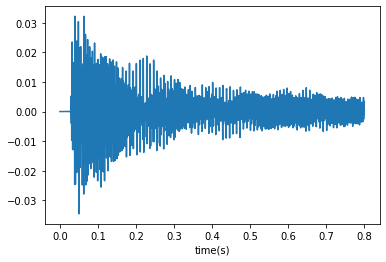

Text(0.5, 0, 'frequency(Hz)')

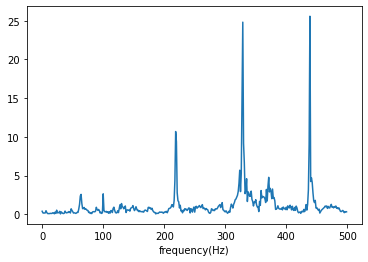

In [40]:
N2=int(0.8*sr)
plt.plot(np.arange(N2)/sr,piano_[:N2])
plt.xlabel("time(s)")
plt.show()
piano_f2 = fft.fft(piano_[:N2])
frequency2=np.linspace(0,sr,N2)
max_f=500 # 設定想看到的最大頻率 (Hz)
max_k2=int(max_freq*N2/sr) # 轉成k
plt.plot(frequency2[:max_k2],abs(piano_f2[:max_k2])) 
plt.xlabel("frequency(Hz)")

我們取第一個音的頻譜來看可看到一個主頻率以及它的harmonics，第一個音的頻率就是這個主頻率
在中間有個主頻率

array([-4.113727 , -7.5971036, -8.141119 , ..., -7.73397  , -8.141119 ,
       -7.5971036], dtype=float32)

Text(0.5, 0, 'frequency(Hz)')

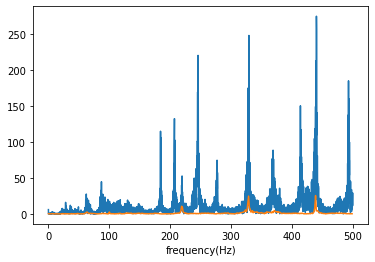

In [39]:
plt.plot(frequency[:max_k],abs(piano_f[:max_k]))
plt.plot(frequency2[:max_k2],abs(piano_f2[:max_k2])) 
plt.xlabel("frequency(Hz)")

擷取與整段對比:
* 整段時長較長，堆積出的能量比較高
* 整段音調混雜，彼此交錯

亦可用```librosa.power_to_db```轉換成分貝頻譜來看，會使scale差比較多的部分較為緩和

Text(0.5, 0, 'frequency(Hz)')

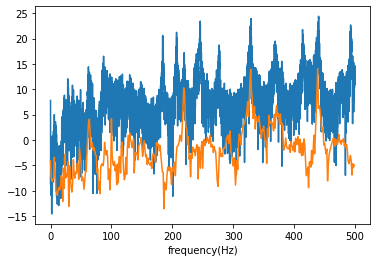

In [96]:
librosa.power_to_db(abs(piano_f2))
plt.plot(frequency[:max_k], librosa.power_to_db(abs(piano_f[:max_k])))
plt.plot(frequency2[:max_k2], librosa.power_to_db(abs(piano_f2[:max_k2]))) 
plt.xlabel("frequency(Hz)")

## Short-Time Fourier Transform

若是想統計出一段內出現哪些音符，則這個FFT就夠用了，但通常想知道的是在每個時間點頻率長什麼樣子就必須要做時頻分析。

時頻分析中最常見的方式就是Sort-Time Fourier Transform:
1. Windowing
2. 個別做頻譜

公式:

$𝑋[q,k]=\sum\limits_{𝑛^′=⌈−𝑁/2⌉}^{⌈𝑁/2⌉−1}𝑥[𝑛^′+𝑞𝐻]𝑤[𝑛^′] 𝑒^\frac{−𝑗2𝜋𝑘𝑛^′}{𝑁}$

* q- 每個window的離散時間點
* k- 離散頻率點
* n'- 原訊號的離散時間點
* N- window內FFT點數，同時是window size
* H- hop size，每個window離多少n'
* w- windowing function
* x- signal

<img src=https://i.imgur.com/Ji4xT6o.png width=600>


Librosa裡面沒有FFT但有很多時頻分析的工具。

我們這邊使用```librosa.stft```來做時頻分析

In [74]:
## 使用librosa.stft可以對訊號做stft
# 'y' - 資料
# 'n_fft' - FFT點數，同時是window長度，這邊就一定要指定了，預設2048，可根據自己想看到的頻率範圍調整
# 'hop_length' - 每個window間要跳多長
# 'window' - windowing function，預設是 'hann'
# 出來是複數 (預設為complex64格式)

N=2048
H=512
piano_S = librosa.stft(piano_,n_fft=N, hop_length=H)

In [75]:
# 可以看出，我們使用librosa STFT可生出一個K x Q 的矩陣 
print(piano_S.shape)
print(type(piano_S))
print(type(piano_S[0,0]))

(1025, 431)
<class 'numpy.ndarray'>
<class 'numpy.complex64'>


In [51]:
# K的大小來自N points/2，因為大於sampling rate/2的訊號會aliase
print(N//2+1)
# Q的大小來自總長度除以hop length，就是windowing的次數
print(len(piano_)//H+1)

1025
431


使用```librosa.display.specshow```可以畫出頻譜圖

In [52]:
import librosa.display as ldp # 顯示訊號工具

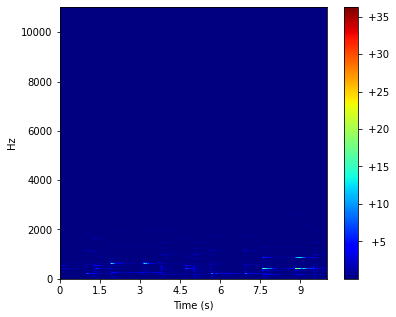

In [64]:
## 使用librosa.display.specshow畫出Spectrogram
# 'data' - Spectrogram
# 'sr' - sampling rate
# 'fmin' - 最小頻率，以Mel scale表達，
# 'x_axis' - x軸刻度單位
# 'y_axis' - y軸刻度單位
# 'cmap' - color map

plt.figure(figsize=(6,5))
ldp.specshow(abs(piano_S),sr=sr,x_axis="s",y_axis="hz",cmap="jet")
plt.colorbar(format="%+4.f")
# plt.clim([-50,10])
plt.show()

若全圖檢視可以看到所有包含的頻率，但其中Y軸的scale有點太大使得較低頻較有資訊的部分看不見，可以擷取一些想看到的低頻頻段來看

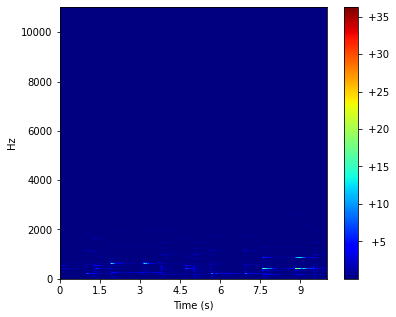

In [103]:
# max_f=500 # 設定想看到的最大頻率 (Hz)
# max_k3=int(max_f*N/sr) # 轉成k
plt.figure(figsize=(6,5))
ldp.specshow(piano_S,sr=sr,x_axis="s",fmin=0,fmax=0.2,y_axis="hz",cmap="jet")
plt.colorbar(format="%+4.f")
# plt.clim([-50,10])
plt.show()

結果如果對比不夠明顯，可以使用```librosa.power_to_db```轉成分貝來看

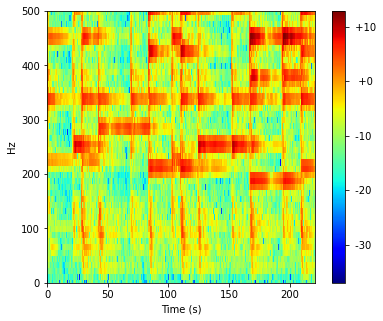

In [100]:
max_f=500 # 設定想看到的最大頻率 (Hz)
max_k3=int(max_f*N/sr) # 轉成k
piano_S_db=librosa.power_to_db(abs(piano_S))
plt.figure(figsize=(6,5))
ldp.specshow(piano_S_db[:max_k3,:],sr=max_f*2,x_axis="s",y_axis="hz",cmap="jet")
plt.colorbar(format="%+4.f")
# plt.clim([-50,10])
plt.show()